In [221]:
import numpy as np
import pandas as pd
import os

In [222]:
!pip install tensorflow

In [223]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

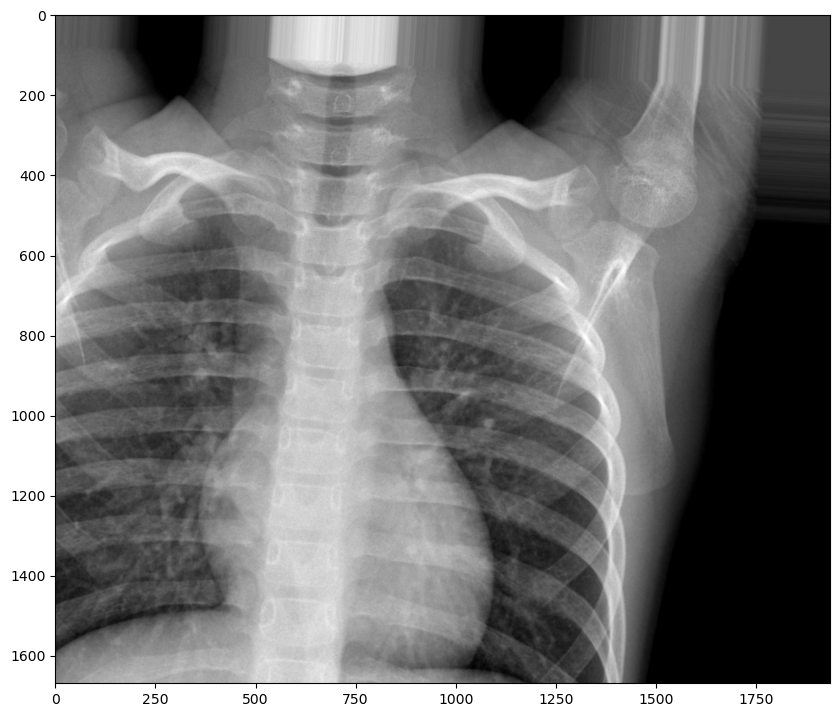

In [224]:
# simply show a picture
plt.figure(figsize= (10, 10))
img = mpimg.imread("Lung Disease Dataset/train/Normal/test_0_9774.jpeg")
plt.imshow(img)
plt.show()

In [225]:
# ImageDataGenerator (only can adjust on training data)
traingen = ImageDataGenerator(rescale= 1./255,
                             width_shift_range=0.2 , 
                             height_shift_range=0.2 ,
                             zoom_range=0.2)
valgen = ImageDataGenerator(rescale= 1./255)
testgen = ImageDataGenerator(rescale= 1./255)

In [226]:
# flow_from_directory
train_it = traingen.flow_from_directory("Lung Disease Dataset/train", target_size = (224, 224))
val_it = traingen.flow_from_directory("Lung Disease Dataset/val", target_size = (224, 224))
test_it = traingen.flow_from_directory("Lung Disease Dataset/test", target_size = (224, 224))

Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.
Found 2023 images belonging to 5 classes.


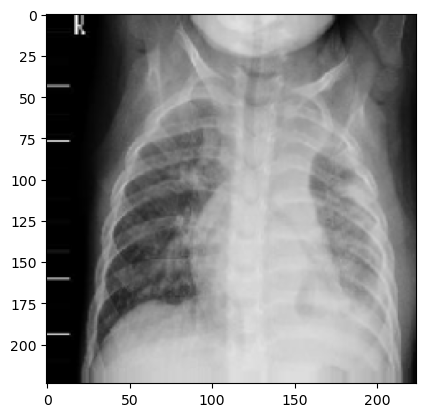

In [227]:
# show the picture after ImageDataGenerator
plt.figure()
plt.imshow(next(train_it)[0][0])
plt.show()

In [228]:
# use pre-train model of DenseNet201
base_model_201 = tf.keras.applications.DenseNet201(input_shape = (224, 224, 3),
    include_top=False,
    weights="imagenet"
)

# lock layers
for layer in base_model_201.layers:
  layer.trainable = False

# set full connect layers
x = layers.Flatten()(base_model_201.output)  # base_model_201.output
x = layers.Dropout(0.5)(x) # 
x = layers.Dense(512, activation= 'relu')(x)
x = layers.Dense(5, activation = 'softmax')(x)

model2 = tf.keras.models.Model(base_model_201.input, x)  # keras.models not keras.model

# compile
model2.compile('adam', loss = 'categorical_crossentropy',metrics = ['acc'])

# you can turn on summary
#model2.summary()

### Earlystop
> This time I forget to use earlystop. Maybe I need to use it next time (because loss and acc don't change at finall)

In [230]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# use checkpoint to save the best model
# use ReduceLROnPlateau to automaticly turn down learning rate
#Checkpoint = tf.keras.callbacks.ModelCheckpoint("densenet201.hdf5", monitor="val_acc", save_best_only= True, mode="max")
reduce_lr = ReduceLROnPlateau(monitor= "val_acc", factor= 0.5, patience= 4, verbose= 3,cooldown=2,  mode= "max", min_lr= 0.0000001)

model2.fit(train_it, validation_data= val_it, epochs=1, callbacks= [reduce_lr], steps_per_epoch=60, validation_steps=10)

60/60 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - acc: 0.5207 - loss: 10.5415 - val_acc: 0.7000 - val_loss: 1.6630 - learning_rate: 0.0010


In [232]:
#model_dense = keras.models.load_model('densenet201.hdf5')
#model_dense.evaluate(test_it, steps= 1)

In [234]:
from IPython.display import display
from tensorflow.keras.preprocessing import image
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array /= 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)

    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    

    classes = ['Bacterial_Pneumonia', 'Corona_Virus_Disease', 'Normal', 'Tuberculosis', 'Viral_Pneumonia']  
    print(f"Predicted Class: {classes[predicted_class]}, Confidence: {confidence:.2f}")
    
    plt.imshow(img)
    plt.title(f"Predicted: {classes[predicted_class]}, Confidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()

def on_file_upload(change):
   
    uploaded_file = change['new']
    if uploaded_file:
        file_path = list(uploaded_file.values())[0]['metadata']['name']
        print(f"File selected: {file_path}")
    
        predict_image(model_dense, file_path)

file_upload = f"BACTERIA-7300836-0001.jpeg"
display(file_upload)


'BACTERIA-7300836-0001.jpeg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Bacterial_Pneumonia, Confidence: 0.95


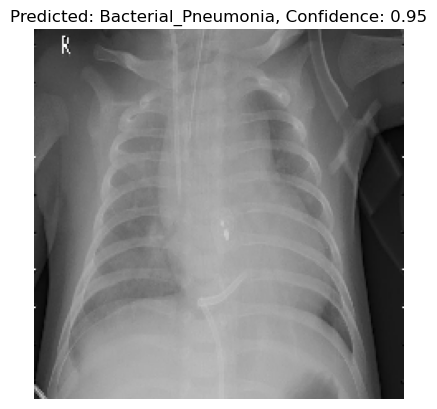

In [235]:
predict_image(model2 , file_upload)